# Introduction
We will obtain MLE Pareto parameter estimates and construct a 95 percent confidence interval for our parameter.

# Packages and Setup

In [129]:
import numpy as np
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

We will create the data which we will use to fit our distribution with the generalized Pareto distribution in SciPy's statistics module.  The generalized Pareto distribution has a probability density function of the form
$$
f(x) = \begin{cases} \frac{1}{\sigma} \left(1 + \xi\left(\frac{x - \mu}{\sigma}\right)\right)^{-1/\xi - 1}, & x\geq \mu\\ 0, &\text{otherwise}\end{cases}
$$
when $\xi \neq 0$ and 
$$
f(x) = \begin{cases} \frac{1}{\sigma} \exp\left(-\frac{x-\mu}{\sigma}\right), & x\geq \mu\\ 0, &\text{otherwise}\end{cases}
$$
when $\xi = 0$. In these forms the SciPy parameters $c$, loc, and scale are $\xi$, $\mu$, and $\sigma$, respectively. SciPy's Pareto functions will not be used after the generation of the random numbers. 

In [130]:
# Set the random seed
np.random.seed(1)

# Create the data
data = stats.genpareto.rvs(c = 0.1, loc = 0, scale = 1, size = 100)

# Convert to data frame
data = pd.DataFrame(data = data, columns = ['result'])

# Sort from smallest to largest
data.sort_values('result', inplace = True)

# Reset the index
data.reset_index(drop = True, inplace = True)

data.head()

,result
0,0.000114
1,0.002875
2,0.018475
3,0.019576
4,0.027808


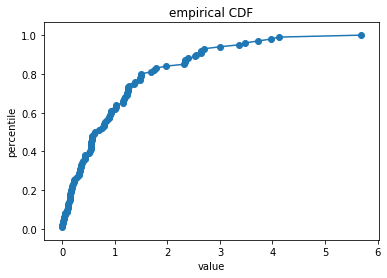

In [131]:
# Plot the empirical cdf
fig, ax = plt.subplots()

ax.plot(data['result'], data['result'].rank(pct = True))
ax.scatter(data['result'], data['result'].rank(pct = True))
ax.set_xlabel('value')
ax.set_ylabel('percentile')
ax.set_title('empirical CDF')

plt.show()

We will construct our pdf, cdf, and ppf. The pdf will be used within the log liklihood function, and we will check how well our result fits the data using the cdf. The ppf function will be used to generate random numbers from the Pareto distribution later.

In [132]:
# Construct pdf
def f(x, mu, sigma, xi):
    
    if x < mu:
        
        y = 0
        
    elif xi == 0:
        
        y = 1/sigma * np.exp(-1/sigma * (x - mu))
        
    else:
        
        y = 1/sigma * (1 + xi/sigma * (x - mu))**(-1/xi - 1)
        
    return y

# Construct cdf
def F(x, mu, sigma, xi):
    
    if x < mu:
        
        y = 0
        
    elif xi == 0:
        
        y = 1 - np.exp(-1/sigma * (x - mu))
        
    else:
        
        y = 1 - (1 + xi/sigma * (x - mu))**(-1/xi)
        
    return y

# Construct ppf
def ppf(u, mu, sigma, xi):
    
    if xi == 0:
        
        x = mu - sigma * np.log(1 - u)
        
    else:
        
        x = mu + sigma/xi * ((1 - u)**-xi - 1)
        
    return x
        
# Create log likelihood function; negate output because optimizer gives minimum
def LL(pars):
    
    fun = np.vectorize(lambda x: f(x, pars[0], pars[1], pars[2]))
    
    if np.sum(data['result'] < pars[0]) > 0:
        
        val = np.Inf
    else:
    
        val = -np.log(fun(data['result'])).sum()
    
    if val is np.nan:
        
        return np.Inf
    
    else:
        
        return val


# MLE parameter estimation
To obtain the parameter estimates, we simply plug our log liklihood function into the optimizer.

In [133]:
result = opt.minimize(LL, x0 = [0, 0.5, 1.5], method = 'Nelder-Mead')
pars = result['x']
result

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


 final_simplex: (array([[1.14359736e-04, 9.95613748e-01, 4.41785964e-02],
       [1.14371379e-04, 9.95639277e-01, 4.41214713e-02],
       [1.14330394e-04, 9.95558948e-01, 4.42112334e-02],
       [1.14327519e-04, 9.95598783e-01, 4.41782070e-02]]), array([104.07683649, 104.07683986, 104.07684059, 104.07684112]))
           fun: 104.07683648578887
       message: 'Optimization terminated successfully.'
          nfev: 187
           nit: 107
        status: 0
       success: True
             x: array([1.14359736e-04, 9.95613748e-01, 4.41785964e-02])

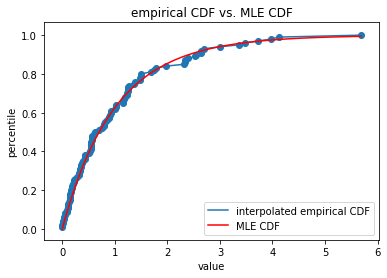

In [134]:
fig, ax = plt.subplots()

xvals = np.linspace(0, data['result'].max(), num = 125)
yvals = [F(x, pars[0], pars[1], pars[2]) for x in xvals]

ax.plot(data['result'], data['result'].rank(pct = True), label = 'interpolated empirical CDF')
ax.scatter(data['result'], data['result'].rank(pct = True))
ax.plot(xvals, yvals, color = 'red', label = 'MLE CDF')

ax.set_xlabel('value')
ax.set_ylabel('percentile')
ax.set_title('empirical CDF vs. MLE CDF')
ax.legend()

plt.show()

# Confidence interval
The next step is to use our parameter estimates to obtain a confidence interval. In particular, we will use the parameters we found before to generate random numbers from the Pareto distribution and then calculate what our parameter estimate would be if the randomly generated numbers were our original data. Standard practice is to generate 10,000 sets of size 100, but we will reduce this to 1,000 to reduce computation time.

In [135]:
# Number of random sets of size 100
N = 1000

# Data frame to save the parameter estimates
parameters = pd.DataFrame(index = range(N), columns = ['mu', 'sigma', 'xi'])

# Data frame to save confidence interval values
confidence_interval = pd.DataFrame(index = ['mu', 'sigma', 'xi'], columns = [2.5, 97.5])

# Generate uniforms and then apply ppf function to generate random numbers from Pareto distribution
uniforms = np.reshape(stats.uniform.rvs(size = 100 * N), (100, N))
vppf = np.vectorize(lambda u: ppf(u, pars[0], pars[1], pars[2]))

# Loop over the sets of random numbers
for i in range(N):
    
    # Redefine data
    data['result'] = vppf(uniforms[:, i])
    
    # Calculate parameter estimate
    parameters.loc[i, :] = opt.minimize(LL, x0 = [0, 0.5, 1.5], method = 'Nelder-Mead')['x']

# Cacluate confidence interval for mu, sigma, and xi, respectively.
for i in range(3):
    
    confidence_interval.iloc[i, :] = parameters.iloc[:, i].quantile([0.025, 0.975]).to_list()

confidence_interval

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,2.5,97.5
mu,0.000314701,0.0386701
sigma,0.722474,1.3071
xi,-0.196514,0.255877


The confidence interval for $\mu$ (mu) does not include 0 because there were probably no samples which contained 0 as a datapoint. The intervals for $\sigma$ (sigma) and $\xi$ (xi) are reasonable; the true parameters lie in about the middle of their corresponding intervals.

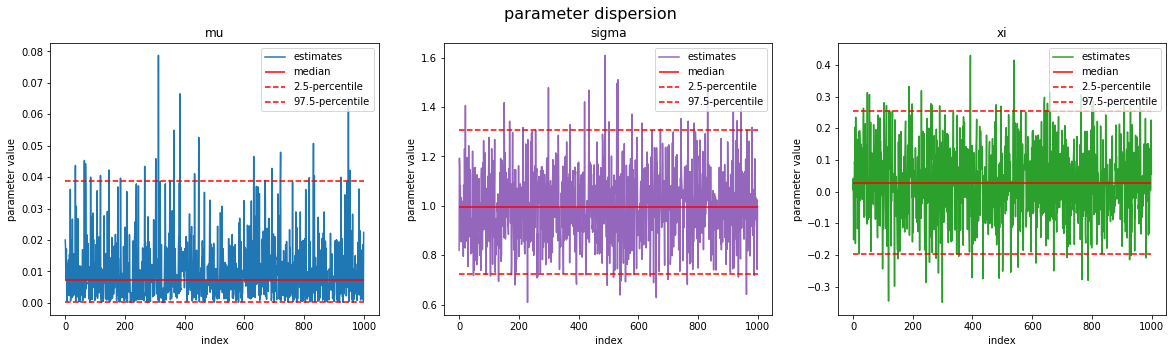

In [138]:
# Plot results to help visualize 
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(parameters.index, parameters['mu'], label = 'estimates', color = '#1f77b4', zorder = 0)
axs[0].hlines(parameters['mu'].median(), xmin = 0, xmax = 999, label = 'median', color = 'red', 
              linewidth = 1.5, zorder = 1)
axs[0].hlines(parameters['mu'].quantile(0.025), xmin = 0, xmax = N - 1, label = '2.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[0].hlines(parameters['mu'].quantile(0.975), xmin = 0, xmax = N - 1, label = '97.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[0].set_xlabel('index')
axs[0].set_ylabel('parameter value')
axs[0].set_title('mu')
axs[0].legend()

axs[1].plot(parameters.index, parameters['sigma'], label = 'estimates', color = '#9467bd', zorder = 0)
axs[1].hlines(parameters['sigma'].median(), xmin = 0, xmax = N - 1, label = 'median', color = 'red', 
              linewidth = 1.5, zorder = 1)
axs[1].hlines(parameters['sigma'].quantile(0.025), xmin = 0, xmax = N - 1, label = '2.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[1].hlines(parameters['sigma'].quantile(0.975), xmin = 0, xmax = N - 1, label = '97.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[1].set_xlabel('index')
axs[1].set_ylabel('parameter value')
axs[1].set_title('sigma')
axs[1].legend()

axs[2].plot(parameters.index, parameters['xi'], label = 'estimates', color = '#2ca02c', zorder = 0)
axs[2].hlines(parameters['xi'].median(), xmin = 0, xmax = N - 1, label = 'median', color = 'red', 
              linewidth = 1.5, zorder = 1)
axs[2].hlines(parameters['xi'].quantile(0.025), xmin = 0, xmax = N - 1, label = '2.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[2].hlines(parameters['xi'].quantile(0.975), xmin = 0, xmax = N - 1, label = '97.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[2].set_xlabel('index')
axs[2].set_ylabel('parameter value')
axs[2].set_title('xi')
axs[2].legend()

fig.suptitle('parameter dispersion', fontsize = 16)

plt.show()